In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', UserWarning)

In [3]:
import sys
#путь с обновленными библиотеками
sys.path.insert(0, '/home/ektov-av/python35-libs/lib/python3.5/site-packages/') 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import os
import sys

from collections import defaultdict

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, \
                            classification_report, precision_score, \
                            recall_score, roc_curve, precision_recall_curve, \
                            average_precision_score, recall_score, make_scorer, \
                            classification_report
                
from sklearn.preprocessing import LabelEncoder
                
from sklearn.cross_validation import train_test_split

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost

# from support_library.plot_support import *
pd.set_option('display.max_columns', None)

%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [4]:
def get_path(folder, file):
    return os.path.join(folder, file)

In [7]:
folder='data_csv/deal'

In [83]:
df = pd.read_pickle('pkl_store/total_dataset.pkl')
cat_features = pd.read_pickle('pkl_store/label_encoders.pkl')

In [14]:
balance = pd.concat([df.groupby('product_group')['is_sold'].sum(), df.groupby('product_group')['is_sold'].count()], axis=1)
balance.columns = ['Count of sold', 'Count']
balance['balance'] = balance['Count of sold'] / balance['Count']
balance = balance.sort_values('balance', ascending=False)
product_groups_without_balance = list(balance[(balance['balance'] == 1) | (balance['balance'] == 0)].index)
df = df[~df['product_group'].isin(product_groups_without_balance)]

In [92]:
target_column = 'is_sold'
X, y = df.drop(target_column, axis = 1), df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [91]:
cat_features_indexes = [X_train.columns.get_loc(col) for col in cat_features if col in X_train.columns]

In [15]:
from lightgbm import LGBMClassifier, plot_metric

In [16]:
gbm = LGBMClassifier(n_estimators=100, num_leaves=10, max_bin=100, bagging_freq=10, n_jobs=20, feature_fraction=0.5,\
                    min_data_in_leaf=100,  silent=False, random_state=42)

In [11]:
%%time
gbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=15,
        eval_metric=['auc', 'logloss'], categorical_feature=cat_features, verbose=False)

CPU times: user 2min 6s, sys: 5.4 s, total: 2min 11s
Wall time: 12.5 s


LGBMClassifier(bagging_freq=10, boosting_type='gbdt', colsample_bytree=1.0,
        feature_fraction=0.5, learning_rate=0.1, max_bin=100, max_depth=-1,
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=100,
        min_split_gain=0.0, n_estimators=100, n_jobs=20, num_leaves=10,
        objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

In [16]:
from support_library.feature_importance import FeatureImportance
from support_library.plot import Plot

In [13]:
y_pred_proba = gbm.predict_proba(X_test)[:,1]

Cross point:  0.887


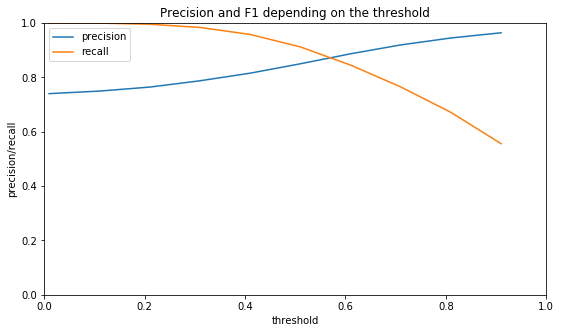

In [14]:
plt=Plot()
plt.precision_recall_threshold_curve(y_test,y_pred_proba)

In [18]:
fi = FeatureImportance(X_train, X_test, y_train, y_test, gbm, X_train.columns)

In [ ]:
permutation_fi = fi.get_permutation_importance()

In [17]:
permutation_fi.head()

,features,permutation_auc
0,tb,0.000134
0,gosb,0.000476
0,type_object,0.000000
0,product,0.022519
0,product_group,0.059798


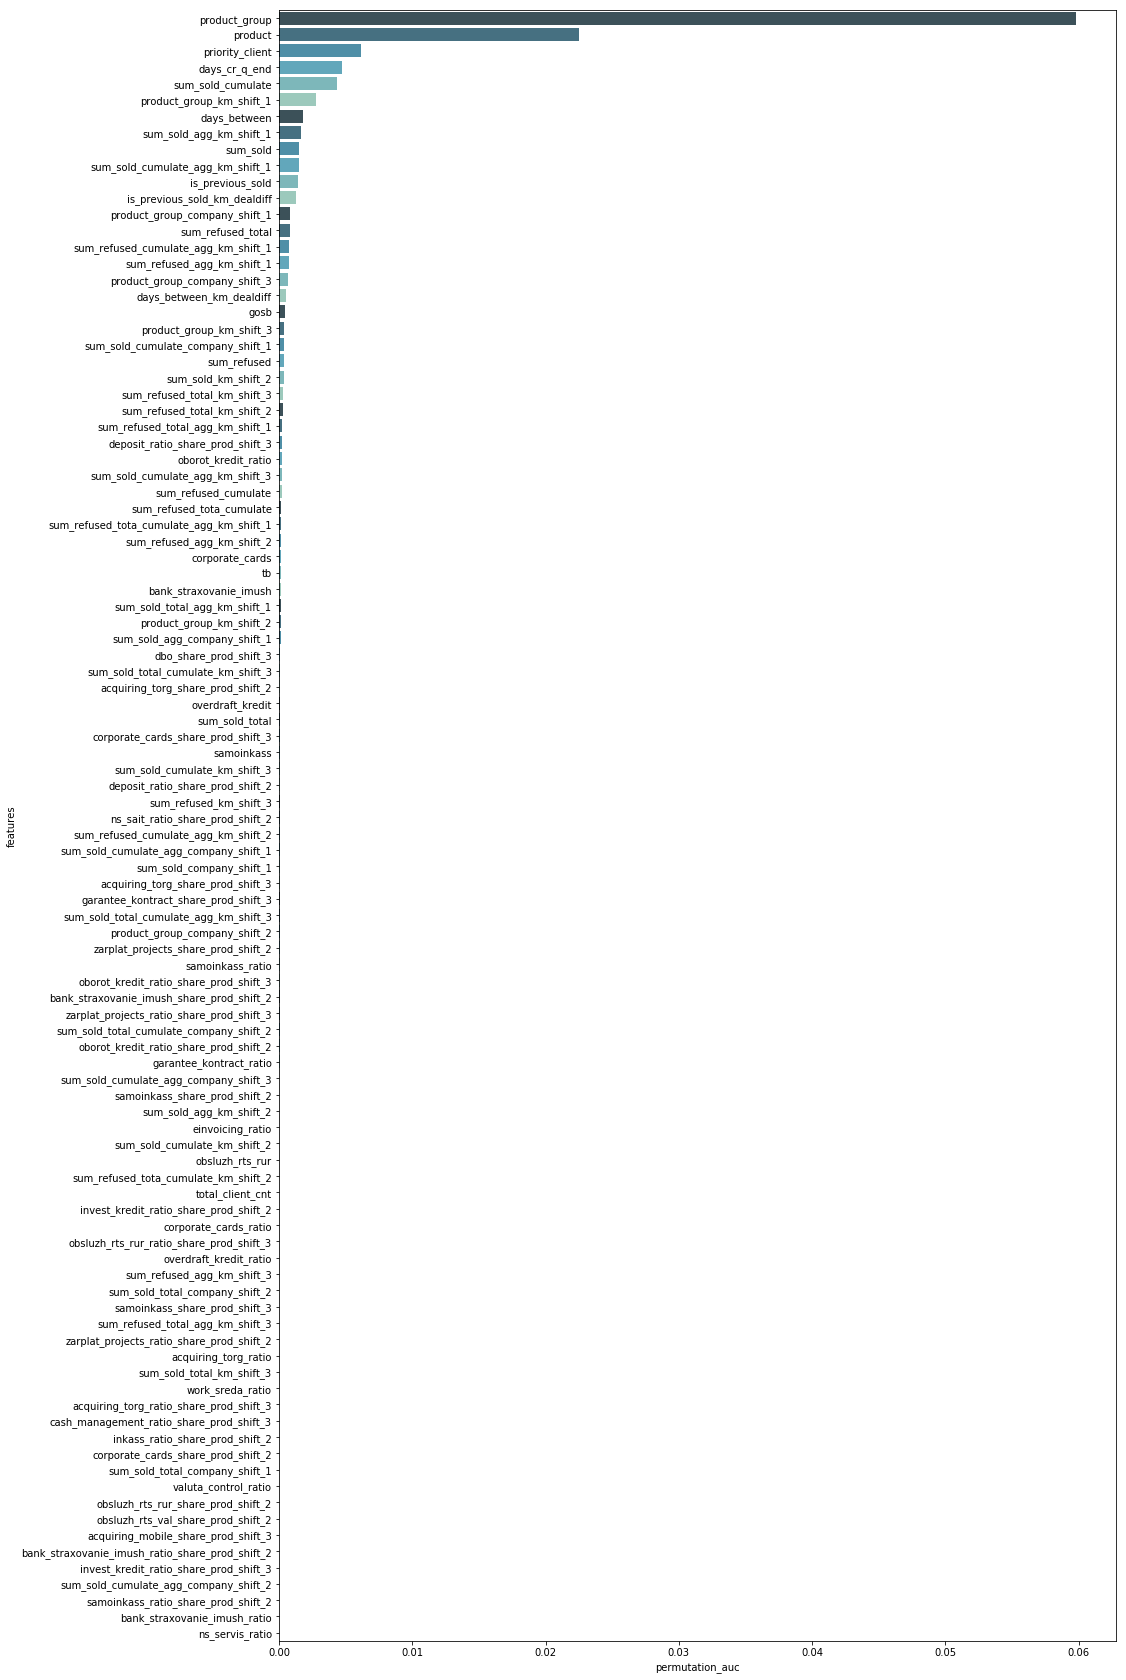

In [18]:
fi.plot_features_importance(permutation_fi, 'permutation')

In [19]:
zero_features = permutation_fi[permutation_fi['permutation_auc'] == 0]['features'].values

In [21]:
gbm.fit(X_train.drop(zero_features, axis=1), y_train)

LGBMClassifier(bagging_freq=10, boosting_type='gbdt', colsample_bytree=1.0,
        feature_fraction=0.5, learning_rate=0.1, max_bin=100, max_depth=-1,
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=100,
        min_split_gain=0.0, n_estimators=100, n_jobs=20, num_leaves=10,
        objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

In [25]:
y_test_prob=gbm.predict_proba(X_test.drop(zero_features, axis=1))[:,1]

In [26]:
roc_auc_score(y_test, y_test_prob)

0.8558576219144383

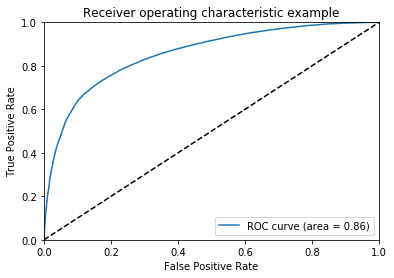

In [27]:
plt.auc_curve(y_test, y_test_prob)

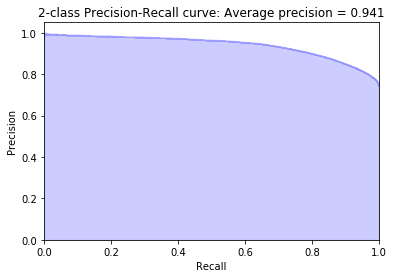

In [28]:
plt.precision_recall_curve(y_test, y_test_prob)

In [ ]:
n_permutation_fi = fi.get_n_permutation_importance(n=4)

In [ ]:
fi.plot_features_importance(n_permutation_fi, 'permutation')

In [ ]:
leave_one_out_fi = fi.get_leave_one_out(n_jobs=5)

In [ ]:
leave_one_out_fi

In [ ]:
list(leave_one_out_fi[leave_one_out_fi['leave_one_out_auc'] <= 0]['features'].values)

In [ ]:
leave_one_out_fi[leave_one_out_fi['leave_one_out_auc'] <= 0.0001]

In [44]:
df['month_n_company_shift_3'].value_counts()

2     28519
1     27861
3     26107
12    18195
11    16482
10    12974
Name: month_n_company_shift_3, dtype: int64

In [43]:
[col for col in df.columns if 'month_' in col]

['month_n_km_shift_1',
 'month_n_company_shift_1',
 'month_n_km_shift_2',
 'month_n_company_shift_2',
 'month_n_km_shift_3',
 'month_n_company_shift_3',
 'month__agg_km_shift_1',
 'month__agg_company_shift_1',
 'month__agg_km_shift_2',
 'month__agg_company_shift_2',
 'month__agg_km_shift_3',
 'month__agg_company_shift_3',
 'month_n_share_prod_shift_1',
 'month_n_share_prod_shift_2',
 'month_n_share_prod_shift_3']

In [37]:
not_impotant_features = set(leave_one_out_fi[leave_one_out_fi['leave_one_out_auc'] <= 0]['features'])

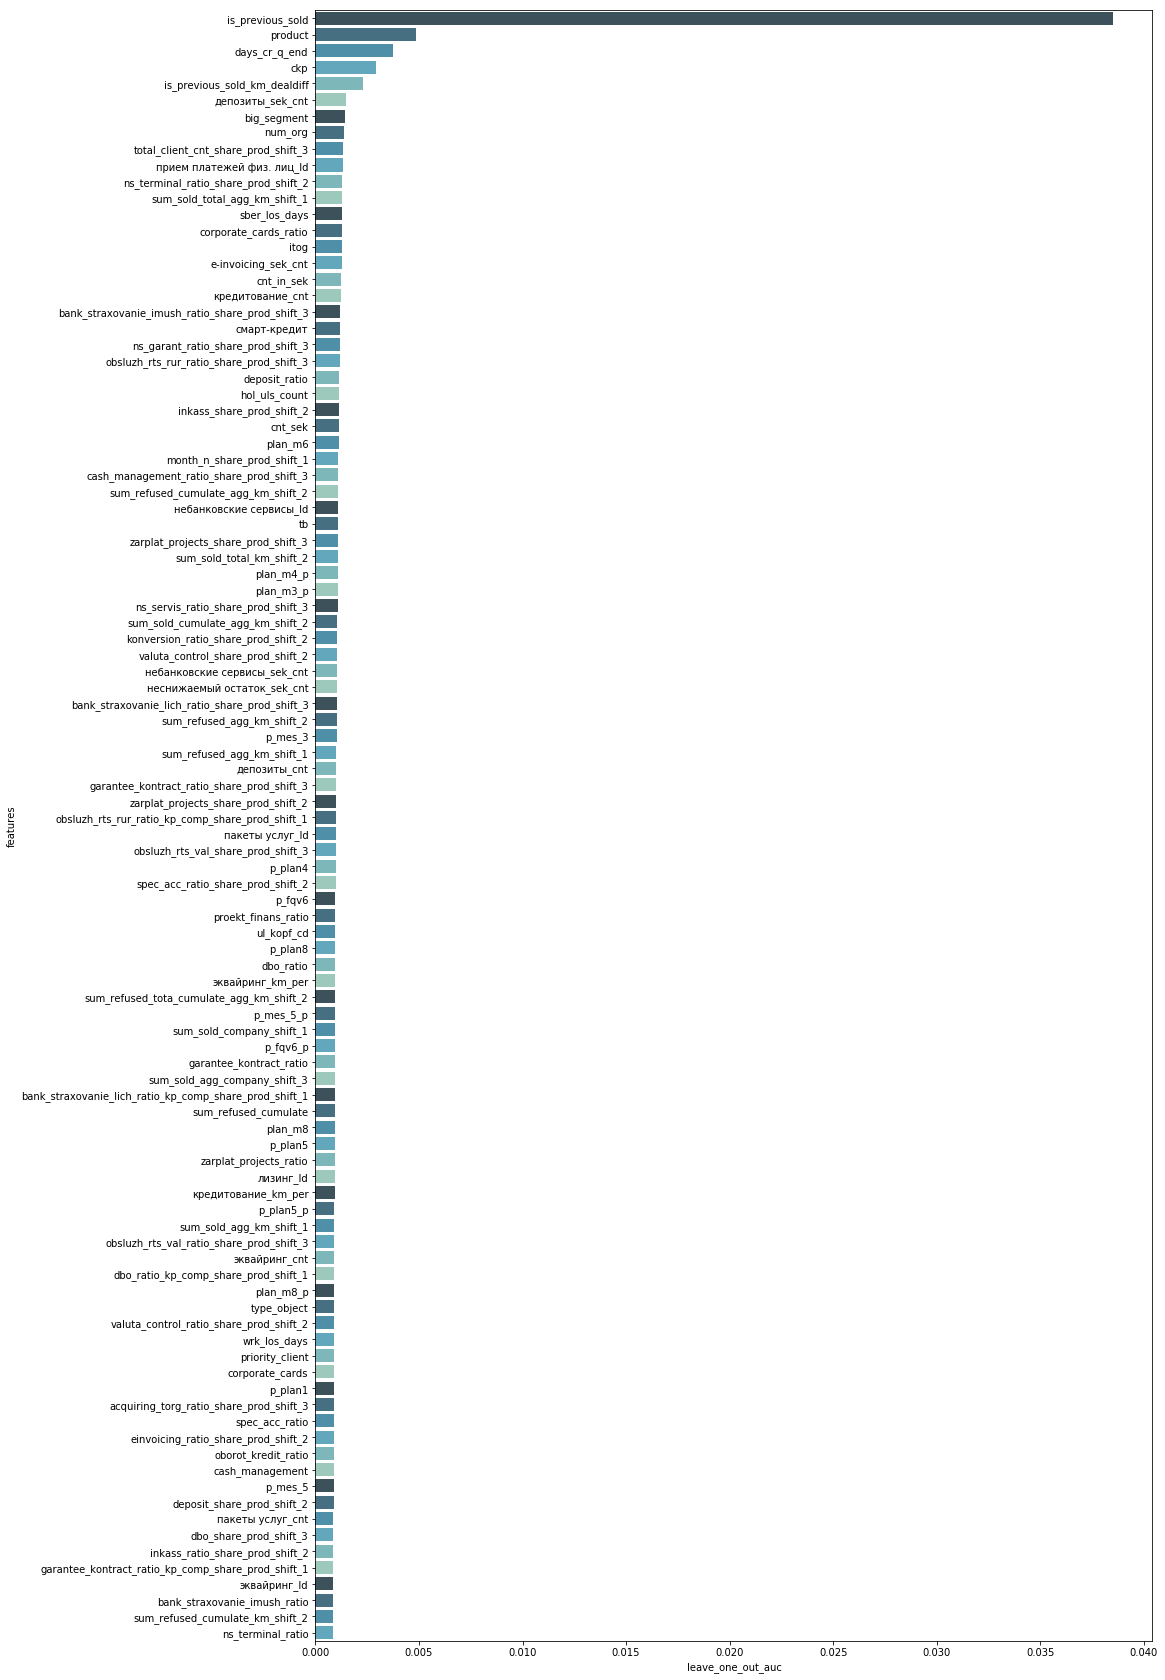

In [24]:
fi.plot_features_importance(leave_one_out_fi, 'leave_one_out')

In [87]:
unique_counts = pd.DataFrame()
for col in df.columns:
    unique_counts = unique_counts.append([[col, len(df[col].unique())]])
unique_counts.columns = ['colname', 'unique_counts']
unique_counts

,colname,unique_counts
0,is_sold,2
0,tb,14
0,gosb,90
0,type_object,1
0,product,138
0,product_group,32
0,days_cr_q_end,92
0,segment_client,2
0,priority_client,9
0,product_group_km_shift_1,33


In [90]:
non_unique_columns = unique_counts[unique_counts['unique_counts'] == 1]['colname'].values

In [94]:
X, y = df.drop(non_unique_columns, axis = 1).drop(target_column, axis = 1), df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [96]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_delta_step=10,
       max_depth=5, min_child_weight=3, missing=None, n_estimators=700,
       n_jobs=10, nthread=64, objective='binary:logistic', random_state=0,
       reg_alpha=1, reg_lambda=10, scale_pos_weight=3.0, seed=42, silent=1,
       subsample=0.8)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_delta_step=10,
       max_depth=5, min_child_weight=3, missing=None, n_estimators=700,
       n_jobs=10, nthread=64, objective='binary:logistic', random_state=0,
       reg_alpha=1, reg_lambda=10, scale_pos_weight=3.0, seed=42, silent=1,
       subsample=0.8)

In [97]:
fi = FeatureImportance(X_train, X_test, y_train, y_test, xgb, X_train.columns)

In [ ]:
one_factor_fi = fi.get_one_factor_importance()

In [ ]:
fi.plot_features_importance(one_factor_fi, 'one_fact')

In [20]:
impotant_features = one_factor_fi[one_factor_fi['one_fact_auc'] > 0.1]['features'].values

In [22]:
%store impotant_features

Stored 'impotant_features' (ndarray)


In [17]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_delta_step=10,
       max_depth=5, min_child_weight=3, missing=None, n_estimators=700,
       n_jobs=10, nthread=64, objective='binary:logistic', random_state=0,
       reg_alpha=1, reg_lambda=10, scale_pos_weight=3.0, seed=42, silent=1,
       subsample=0.8)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_delta_step=10,
       max_depth=5, min_child_weight=3, missing=None, n_estimators=700,
       n_jobs=10, nthread=64, objective='binary:logistic', random_state=0,
       reg_alpha=1, reg_lambda=10, scale_pos_weight=3.0, seed=42, silent=1,
       subsample=0.8)

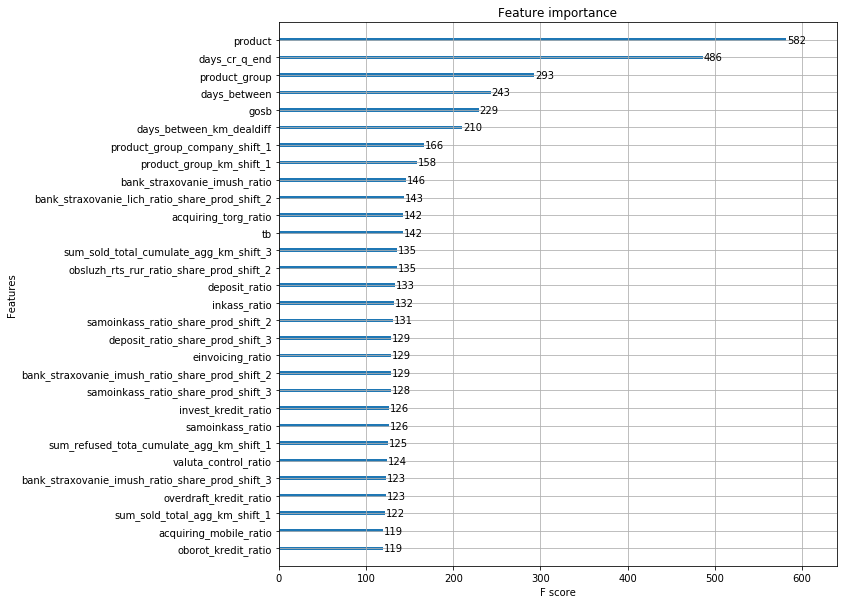

In [22]:
ax = xgboost.plot_importance(xgb.get_booster(), importance_type='weight', max_num_features=30)
fig = ax.figure
fig.set_size_inches(10, 10)

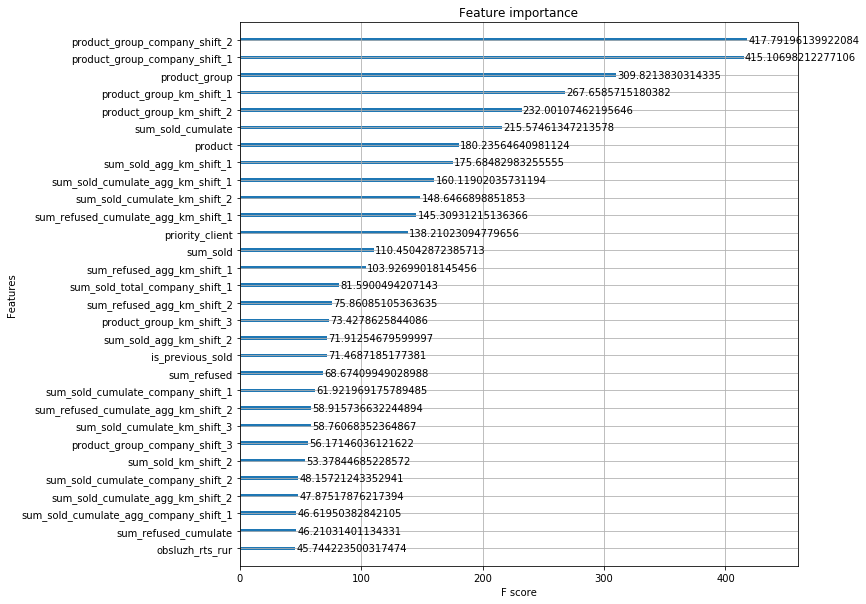

In [23]:
ax = xgboost.plot_importance(xgb.get_booster(), importance_type='gain', max_num_features=30)
fig = ax.figure
fig.set_size_inches(10, 10)

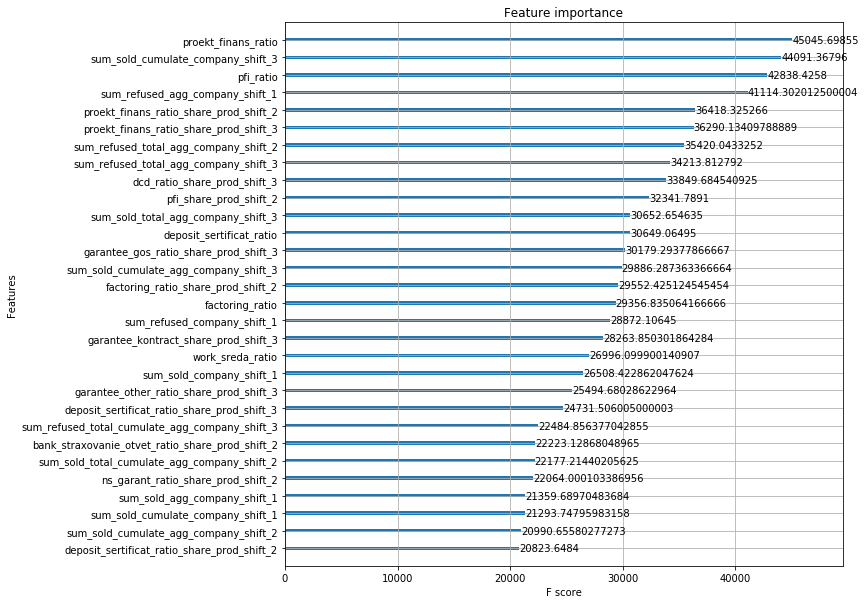

In [24]:
ax = xgboost.plot_importance(xgb.get_booster(), importance_type='cover', max_num_features=30)
fig = ax.figure
fig.set_size_inches(10, 10)

In [25]:
booster = xgb.get_booster()

In [26]:
sorted(booster.get_score(importance_type='gain').items(), key=lambda x: x[1], reverse=True)[:20]

[('product_group_company_shift_2', 417.79196139922084),
 ('product_group_company_shift_1', 415.10698212277106),
 ('product_group', 309.8213830314335),
 ('product_group_km_shift_1', 267.6585715180382),
 ('product_group_km_shift_2', 232.00107462195646),
 ('sum_sold_cumulate', 215.57461347213578),
 ('product', 180.23564640981124),
 ('sum_sold_agg_km_shift_1', 175.68482983255555),
 ('sum_sold_cumulate_agg_km_shift_1', 160.11902035731194),
 ('sum_sold_cumulate_km_shift_2', 148.6466898851853),
 ('sum_refused_cumulate_agg_km_shift_1', 145.30931215136366),
 ('priority_client', 138.21023094779656),
 ('sum_sold', 110.45042872385713),
 ('sum_refused_agg_km_shift_1', 103.92699018145456),
 ('sum_sold_total_company_shift_1', 81.5900494207143),
 ('sum_refused_agg_km_shift_2', 75.86085105363635),
 ('product_group_km_shift_3', 73.4278625844086),
 ('sum_sold_agg_km_shift_2', 71.91254679599997),
 ('is_previous_sold', 71.4687185177381),
 ('sum_refused', 68.67409949028988)]

In [20]:
import shap
shap.initjs()

In [21]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)

In [ ]:
shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X_train)

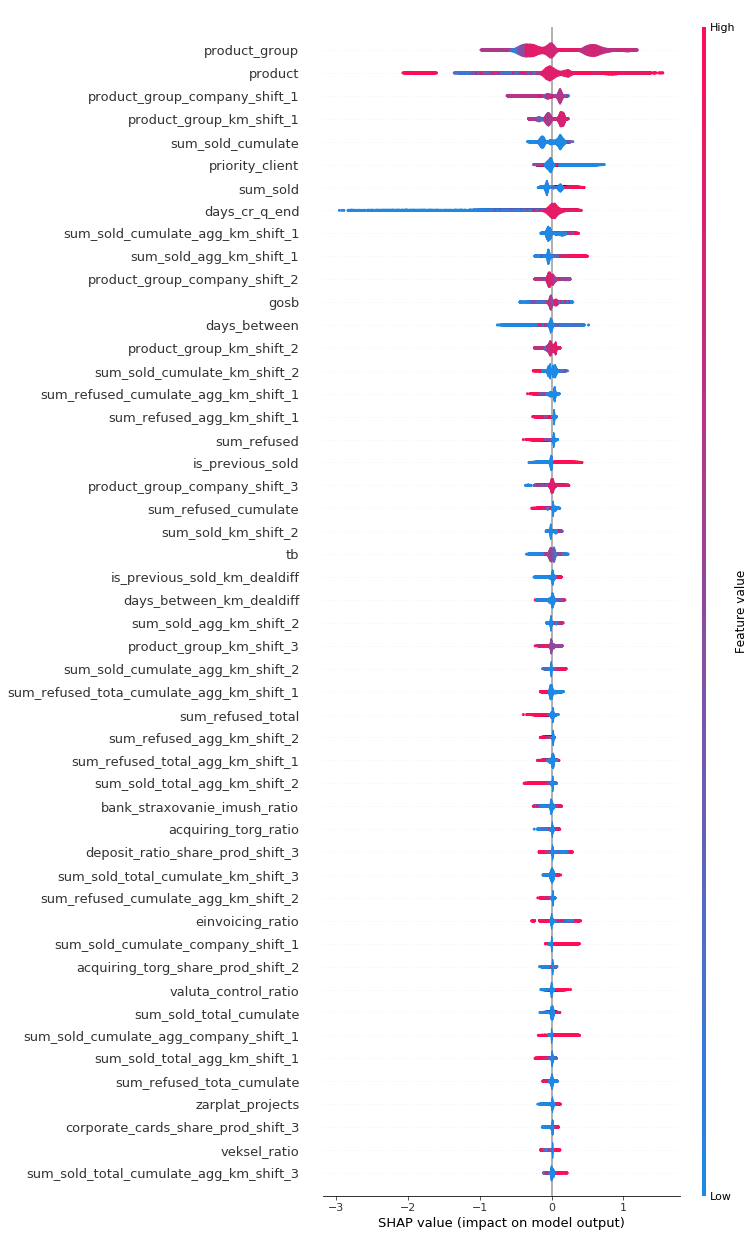

In [22]:
shap.summary_plot(shap_values, X_train, max_display=50, plot_type='violin')

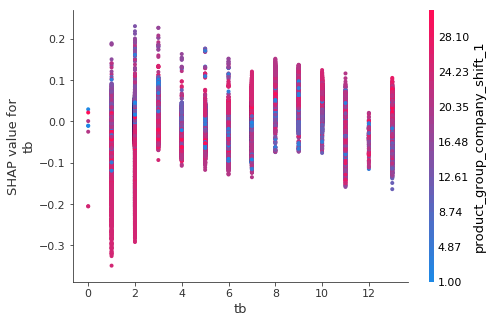

In [25]:
shap.dependence_plot('tb', shap_values, X_train)

In [27]:
X_train['product_group_company_shift_1'].unique()

array([26, 17, 21,  4, 22, 16,  1, 14, 11, 32, 25, 28, 31, 20,  3,  5, 23,
        7,  9, 19, 10, 12, 29,  8, 13,  0, 30, 15, 24])

In [120]:
def feature_impotance(model, X_train, count_top_features = 20):
    imp=model.feature_importances_
    names=X_train.columns
    imp, names=map(list, zip(*sorted(zip(imp, names))[::-1][:count_top_features]))

    ax = plt.axes()
    sns.barplot(x=imp, y=names, palette=sns.color_palette('YlGn', 2), ax=ax)
    ax.set_title('Top ' + str(count_top_features) + ' important features')
    plt.show()
    
def eval_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, )

    print('Test set (without balance)')
    y_test_pred_model = model.predict(X_test)
    print(classification_report(y_test, y_test_pred_model, digits=5))
    print('F1 weighted %.5f' % f1_score(y_test, y_test_pred_model, average='weighted'))
    print('ROC-AUC score %.5f' % roc_auc_score(y_test, y_test_pred_model))
    confusion_matrix_heatmap(y_test, y_test_pred_model)
    print()

Test set (without balance)


/home/kaarestov/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0    0.80874   0.47284   0.59677       626
          1    0.84536   0.96265   0.90020      1874

avg / total    0.83619   0.84000   0.82422      2500

F1 weighted 0.82422
ROC-AUC score 0.71775


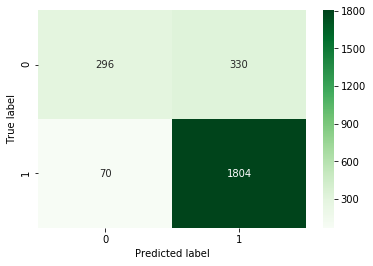

In [126]:
eval_model(xgb, X_train, y_train, X_test, y_test)

In [127]:
unique_counts = pd.DataFrame()
for col in data.columns:
    unique_counts = unique_counts.append([[col, len(data[col].unique())]])
unique_counts.columns = ['colname', 'unique_counts']

In [128]:
non_unique_columns = unique_counts[unique_counts['unique_counts'] == 1]['colname'].values

In [129]:
X, y = df_sample[col_num_list].drop(non_unique_columns, axis = 1).drop(target_column, axis = 1), df_sample[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Test set (without balance)
             precision    recall  f1-score   support

          0    0.82192   0.47923   0.60545       626
          1    0.84731   0.96531   0.90247      1874

avg / total    0.84095   0.84360   0.82810      2500

F1 weighted 0.82810
ROC-AUC score 0.72227


/home/kaarestov/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


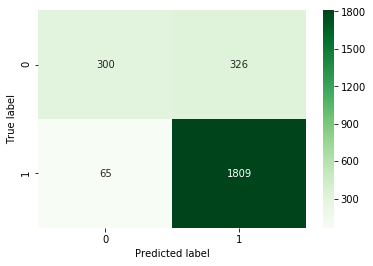

In [130]:
eval_model(xgb, X_train, y_train, X_test, y_test)

## Polynomial Features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
booster = xgb.get_booster()
top_features = sorted(booster.get_score(importance_type='gain'), key=lambda x: x[1], reverse=True)[:20]

In [149]:
top_features

['Открытие банковского счета без договора-конструктора_cnt',
 'Страхование НС_sek_cnt',
 'Страхование НС_cnt',
 'Открытие банковского счета с договором-конструктором_sek_cnt',
 'Страхование корпоративных карт для ИП_ld',
 'Страхование.1',
 'Страхование_ld',
 'Открытие банковского счета с договором-конструктором_ld',
 'Стабильный бизнес_ld',
 'Открытие банковского счета без договора-конструктора_km_per',
 'Страхование НС_km_per',
 'Открытие банковского счета с договором-конструктором_cnt',
 'Страхование_cnt.1',
 'Открытие банковского счета с договором-конструктором_km_per',
 'Страхование_km_per.1',
 'Страхование корпоративных карт для ИП_km_per',
 'Страхование НС_ld',
 'Стабильный бизнес',
 'Стабильный бизнес_sek_cnt',
 'Открытие банковского счета без договора-конструктора_sek_cnt']

In [161]:
pf = PolynomialFeatures(include_bias=False)

In [162]:
pol_features = pd.DataFrame(pf.fit_transform(df_sample[top_features]), columns=pf.get_feature_names(df_sample[top_features].columns))

In [ ]:
pol_features.head()

In [188]:
pol_features.index = df_sample.index

In [175]:
pol_features.shape, df_sample.shape

((10000, 230), (10000, 930))

In [189]:
df_with_pol_features = pd.concat([df_sample, pol_features], axis=1, ignore_index=True)

In [190]:
df_with_pol_features.shape

(10000, 1160)

In [ ]:
df_with_pol_features.head()

In [192]:
X, y = df_sample[col_num_list].drop(non_unique_columns, axis = 1).drop(target_column, axis = 1), df_sample[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Test set (without balance)
             precision    recall  f1-score   support

          0    0.82192   0.47923   0.60545       626
          1    0.84731   0.96531   0.90247      1874

avg / total    0.84095   0.84360   0.82810      2500

F1 weighted 0.82810
ROC-AUC score 0.72227


/home/kaarestov/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


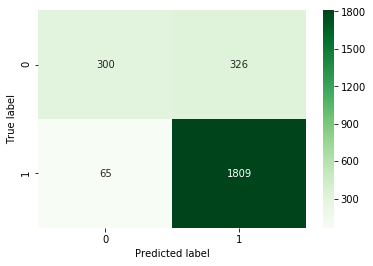

In [193]:
eval_model(xgb, X_train, y_train, X_test, y_test)

In [198]:
xgb = XGBClassifier(n_estimators=1000)

In [200]:
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='logloss', early_stopping_rounds=20)

[0]	validation_0-logloss:0.640293	validation_1-logloss:0.64047
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.597108	validation_1-logloss:0.597851
[2]	validation_0-logloss:0.561151	validation_1-logloss:0.562168
[3]	validation_0-logloss:0.531113	validation_1-logloss:0.532861
[4]	validation_0-logloss:0.505698	validation_1-logloss:0.507815
[5]	validation_0-logloss:0.483859	validation_1-logloss:0.486396
[6]	validation_0-logloss:0.465399	validation_1-logloss:0.468417
[7]	validation_0-logloss:0.449506	validation_1-logloss:0.453162
[8]	validation_0-logloss:0.435789	validation_1-logloss:0.439674
[9]	validation_0-logloss:0.423919	validation_1-logloss:0.42837
[10]	validation_0-logloss:0.414214	validation_1-logloss:0.418954
[11]	validation_0-logloss:0.405797	validation_1-logloss:0.410764
[12]	validation_0-logloss:0.3985	validation_1-logloss:0.403889
[13]

[124]	validation_0-logloss:0.274041	validation_1-logloss:0.335669
[125]	validation_0-logloss:0.273695	validation_1-logloss:0.335701
[126]	validation_0-logloss:0.273334	validation_1-logloss:0.335881
[127]	validation_0-logloss:0.272682	validation_1-logloss:0.3357
[128]	validation_0-logloss:0.272438	validation_1-logloss:0.335704
[129]	validation_0-logloss:0.271813	validation_1-logloss:0.335613
[130]	validation_0-logloss:0.271363	validation_1-logloss:0.335745
[131]	validation_0-logloss:0.270849	validation_1-logloss:0.335845
[132]	validation_0-logloss:0.27059	validation_1-logloss:0.335953
Stopping. Best iteration:
[112]	validation_0-logloss:0.280729	validation_1-logloss:0.335181



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)